<a href="https://colab.research.google.com/github/GuyWhoCodesThings/NLP-projects/blob/main/Emotion_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [493]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical  
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn import preprocessing
import random

data from:
https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=val.txt

also credit to ashu prasad as the inspiriation for the tokenization, his blog here: https://towardsdatascience.com/natural-language-processing-with-tensorflow-e0a701ef5cef

In [494]:
BATCH_SIZE = 64
BUFFER_SIZE = 2000

In [495]:
with open('/content/drive/MyDrive/KaggleDatasets/train.txt') as f:
    contents = f.readlines()

In [496]:
split_txt = []
for i in range (len(contents)):
  split_txt.append(contents[i].split(';'))

In [497]:
sentences = []
emotions = []
for i in range (len(contents)):
  sentences.append(split_txt[i][0])
  emotions.append(split_txt[i][1])

In [498]:
labels = np.array(emotions)
labels = labels.astype('str')
unique_labels = np.unique(labels)
print(unique_labels)

['anger\n' 'fear\n' 'joy\n' 'love\n' 'sadness\n' 'surprise\n']


In [499]:
label_dict = {
    'anger\n':0,
    'fear\n':1,
    'joy\n':2,
    'love\n':3,
    'sadness\n':4,
    'surprise\n':5
}

In [500]:
#get labels from string to int
int_labels = []
for i in range(len(labels)):
  int_labels.append(label_dict[labels[i]])

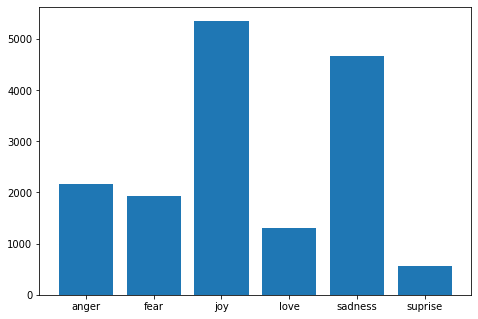

In [501]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
names = ['anger', 'fear', 'joy', 'love', 'sadness', 'suprise']
anger = int_labels.count(0)
fear = int_labels.count(1)
joy = int_labels.count(2)
love = int_labels.count(3)
sadness = int_labels.count(4)
suprise = int_labels.count(5)
amount = [anger, fear, joy, love, sadness, suprise]
ax.bar(names,amount)
plt.show()

In [502]:
catagorical_labels = np.array(to_categorical(int_labels, num_classes = (len(unique_labels))))
sentences=np.array(sentences)

In [503]:
def split_data(input, train_split=0.8, val_split=0.1):
  length = len(input)
  train = input[:int(length*train_split)]
  val = input[int(length*train_split):int(length*val_split + length*train_split)]
  test = input[int(length*val_split + length*train_split):]
  return train, val, test


In [504]:
len(sentences)

16000

In [505]:
x_train, x_val, x_test = split_data(sentences, train_split=0.9, val_split=0.05)
y_train, y_val, y_test = split_data(catagorical_labels, train_split=0.9, val_split=0.05)

In [588]:
def get_sequence(input):
  sequences = tokenizer.texts_to_sequences(input)
  return pad_sequences(sequences, padding='post', maxlen=training_padded.shape[-1])

In [507]:
tokenizer = Tokenizer(num_words=500, oov_token = "<00V>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, padding='post', truncating='post')
val_padded = get_sequence(x_val)
test_padded = get_sequence(x_test)

In [508]:
print(training_padded.shape)
print(val_padded.shape)
print(test_padded.shape)

(14400, 66)
(800, 66)
(800, 66)


In [509]:
print(training_padded[0])

[  2 134   3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [510]:
y_train.shape

(14400, 6)

In [511]:
print("num of vocab words in training are: ", len(word_index))

num of vocab words in training are:  14422


In [512]:
train_ds = tf.data.Dataset.from_tensor_slices((training_padded, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val_padded, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((test_padded, y_test))

In [513]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [529]:
def build_model(vocab_size, embed_dim, max_length):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv1D(128, 5, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(72)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='linear')
  ])

  return model

In [530]:
model = build_model(len(word_index), 16, training_padded.shape[-1])

In [531]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [532]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 66, 16)            230752    
                                                                 
 dropout_17 (Dropout)        (None, 66, 16)            0         
                                                                 
 conv1d_20 (Conv1D)          (None, 62, 128)           10368     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 15, 128)          0         
 g1D)                                                            
                                                                 
 bidirectional_17 (Bidirecti  (None, 144)              115776    
 onal)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 144)             

In [533]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [534]:
epochs=6
history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds,
  callbacks=callbacks
)

Epoch 1/6
225/225 [==============================] - 12s 41ms/step - loss: 1.5942 - accuracy: 0.3346 - val_loss: 1.5866 - val_accuracy: 0.3787 - lr: 0.0010
Epoch 2/6
225/225 [==============================] - 8s 35ms/step - loss: 1.4166 - accuracy: 0.4585 - val_loss: 1.2900 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 3/6
225/225 [==============================] - 8s 35ms/step - loss: 1.2081 - accuracy: 0.5377 - val_loss: 1.1435 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 4/6
225/225 [==============================] - 8s 34ms/step - loss: 1.1240 - accuracy: 0.5703 - val_loss: 1.1087 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 5/6
225/225 [==============================] - 8s 35ms/step - loss: 1.0908 - accuracy: 0.5760 - val_loss: 1.0972 - val_accuracy: 0.5788 - lr: 0.0010
Epoch 6/6
225/225 [==============================] - 8s 33ms/step - loss: 1.0602 - accuracy: 0.5883 - val_loss: 1.0757 - val_accuracy: 0.5587 - lr: 0.0010


In [535]:
def get_model_preformance(model_history):
  history = model_history
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
plt.show()


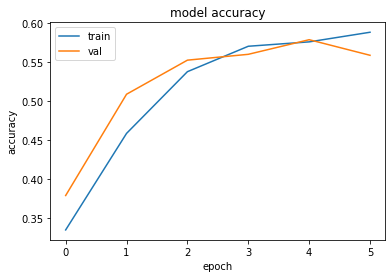

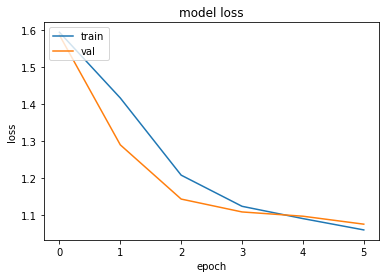

In [536]:
get_model_preformance(history)

In [537]:
model.evaluate(test_padded, y_test)

25/25 [==============================] - 1s 8ms/step - loss: 1.0757 - accuracy: 0.5587


[1.0756925344467163, 0.5587499737739563]

In [538]:
print(test_padded[0].shape)

(66,)


In [539]:
num_to_labels = {
    0:'anger',
    1:'fear',
    2:'joy',
    3:'love',
    4:'sadness',
    5:'surprise'
}

In [624]:
def get_prediction(text, from_num):
    if from_num == False:
      text = get_sequence(text)
    predict = model.predict(text)
    results = np.argmax(predict, axis=1)
    return num_to_labels[results[0]]

In [642]:
num_of_tests = 5
correct = 0
for i in range(num_of_tests):
  index = random.randint(0,test_padded.shape[-1] - 1)
  print('sentence is: ', x_test[index])
  print(x_test[index])
  pred = get_prediction(test_padded[index].reshape(1,66), True)
  print('model prediction is: ', pred) 
  actual = num_to_labels[np.argmax(y_test[index])]
  print('actual emotion was: ', actual)
  if actual == pred:
    correct += 1
print('number of correct predictions: ', correct, '/', num_of_tests)

sentence is:  i alsways feel so carefree
i alsways feel so carefree
model prediction is:  sadness
actual emotion was:  joy
sentence is:  i feel liked i talked about mass effect to death in these posts but i m going to have to again i m afraid
i feel liked i talked about mass effect to death in these posts but i m going to have to again i m afraid
model prediction is:  love
actual emotion was:  love
sentence is:  i feel frustrated about especially last night is not in doing all those things i actually enjoy them but in finding the time to do them
i feel frustrated about especially last night is not in doing all those things i actually enjoy them but in finding the time to do them
model prediction is:  anger
actual emotion was:  anger
sentence is:  i miss feeling like i hated you
i miss feeling like i hated you
model prediction is:  sadness
actual emotion was:  anger
sentence is:  i feel a little sad about it but christmas is hardly on
i feel a little sad about it but christmas is hardly

In [644]:
user_input = input('please enter a sentence: ')
print('model prediction is: ', get_prediction([user_input], False))


please enter a sentence: I was working with my program and the computer came to life shiver me timbers I was so scared
model prediction is:  fear
